# Import Library

In [1]:
import os
from pathlib import Path

import pandas as pd
import joblib
import shap

c:\Users\11413929\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def process_training(df):
    df['feat_avg_contribution'] = df['feat_avg_contribution'].fillna(0)

    for col in ['feat_is_blocked_recently', 'feat_is_unblocked_recently', 'feat_is_rename_user_recently']:
        df[col] = df[col].fillna(0)
        df[col] = df[col].astype(int)

    df['feat_count_comment_bad_user'] = df['feat_count_comment_bad_user'].fillna(0)
    df['feat_count_comment_bad_user'] = df['feat_count_comment_bad_user'].astype(int)

    if 'log_timestamp' in df.columns:
        df['log_timestamp'] = pd.to_datetime(df['log_timestamp'])

# Import Files

In [3]:
path = Path(os.getcwd())

project_dir = path.parent

interim_data_dir = project_dir / 'data' / 'interim'
process_data_dir = project_dir / 'data' / 'preprocess'
prediciton_data_dir = project_dir / 'data' / 'prediction'
final_model_dir = project_dir / 'model' / 'final'

In [4]:
# model
p = final_model_dir.glob('*.joblib')
list_file_names = [str(x) for x in p]
latest_model_file = sorted(list_file_names, reverse=True).pop(0)

model = joblib.load(latest_model_file)

In [5]:
# data
id_cols = ['log_id', 'user_id']
target_col = 'is_block_next_period'

df = pd.read_csv(process_data_dir / "test_data.csv").set_index(id_cols)

# predicted values
df_pred = pd.read_csv(prediciton_data_dir / "test_data.csv")

# Preprocess Data

In [6]:
process_training(df)

X = df.filter(regex='^feat', axis=1)
y = df[target_col]

# Analysis

In [7]:
tree_explainer = shap.TreeExplainer(model)
shap_values = tree_explainer(X)

## SHAP Global Feature Importance

Determine feature importance based on the global average of absolute SHAP values

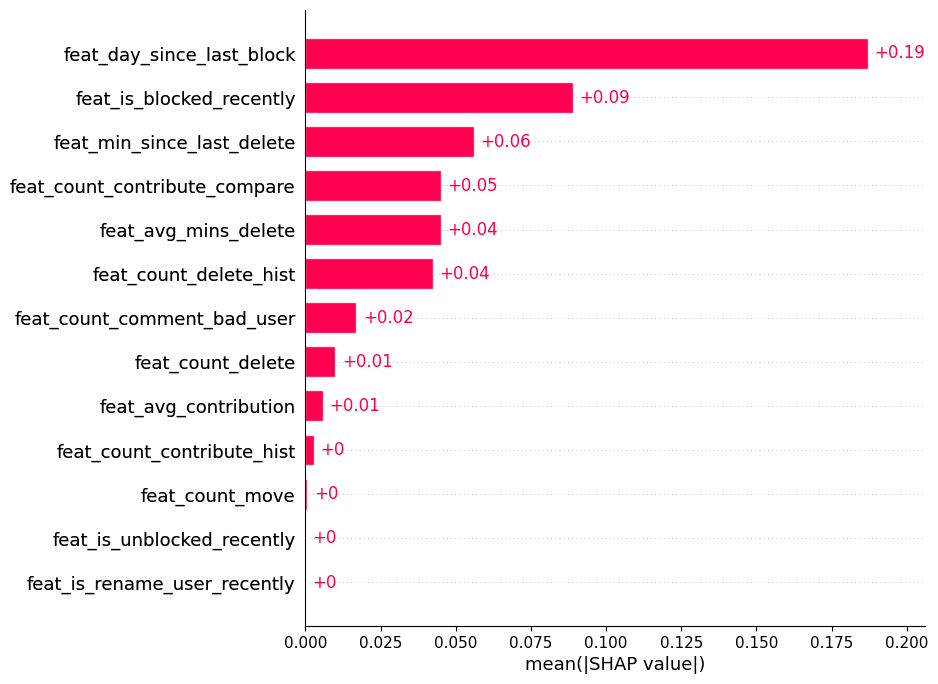

In [8]:
shap.plots.bar(shap_values[:,:,1], max_display=13)

From the graph, we can see that
 - The most importance features which, in average, dominates the most of prediction are all the features related to user bans history (1-2)
 - The second-most importance features are related to <code>'delete'</code> action in terms of both recency and frequency (3, 5-6)
 - Features related to <code>'create'</code> action, however, don't contribute to the prediction as much as expected. (4, 9)

## SHAP Summary Plot

Determine the type of impact (postive/negative) on model prediction based on the magnitude of feature value (high or low)

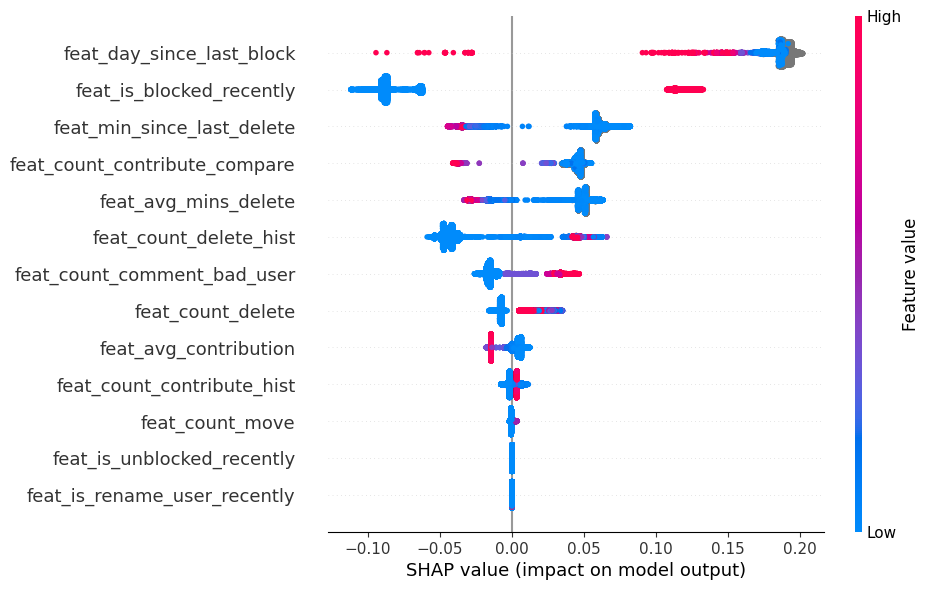

In [9]:
# reference : https://stackoverflow.com/questions/76083485/shap-instances-that-have-more-than-one-dimension
shap.plots.beeswarm(shap_values[:,:,1], max_display=13)

From the graph, we can inspect the model's predictive behavior as
 - Recent <code>'block'</code> history indicates a higher chance of disruptive behaviors, which leads to more user bans in the future (1-2)
 - High level of <code>'delete'</code> activity, indicating by an repeated attempt to delete contents within a short period of time, also indicates disruptive behaviors that pose a threat to the community. (3, 5-6, 8)
 - Semantic meaning of comments also helps detecting destructive behaviors as well (7)
 - User with high contribution (<code>'create'</code> action) are less likely to become a threat to community (4, 9).

## Model Prediction with High-Confidence

To determine a scenario where we can fully trust the prediction, we can analyze key attributes of correct predicted examples on destructive behaviors (target = 1) with high confidence (prob > 0.8) by looking at its feature values

In [10]:
pred_prob = model.predict_proba(X)
pred_prob = pred_prob[:, 1]

In [11]:
log_id_correct = df_pred.loc[df_pred['is_block_next_period'].eq(df_pred['y_pred']) & (pred_prob > 0.8), 'log_id']
feature_high_confidence = X.loc[X.index.get_level_values(0).isin(log_id_correct)]

In [12]:
feature_high_confidence['feat_day_since_last_block'].value_counts()

feat_day_since_last_block
0.0    804
Name: count, dtype: int64

In [13]:
feature_high_confidence['feat_is_blocked_recently'].value_counts()

feat_is_blocked_recently
1    804
Name: count, dtype: int64

All correctly predicted examples with high confidence are associated with getting banned from other users <b>in the same day</b>

<Axes: >

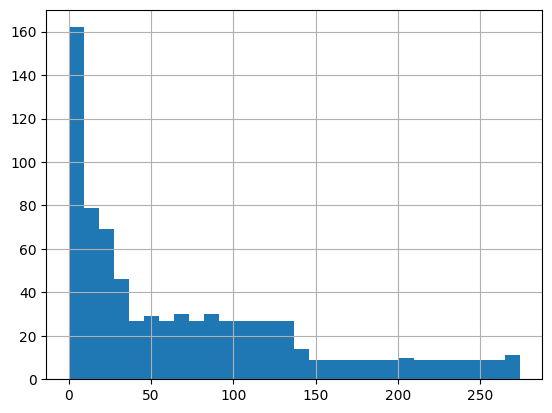

In [14]:
# graph 1
feature_high_confidence['feat_count_delete'].hist(bins=30)

<Axes: >

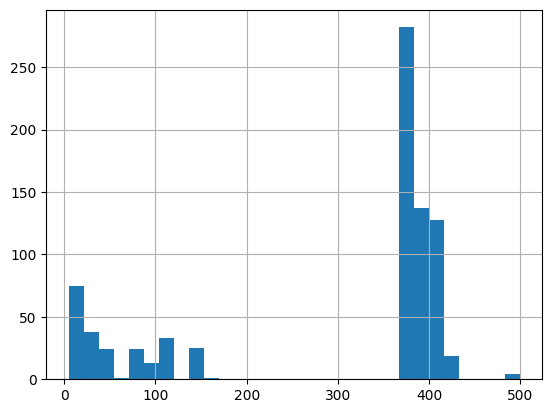

In [15]:
# graph 2
feature_high_confidence['feat_count_delete_hist'].hist(bins=30)

Most of correctly predicted examples with high confidence are related to <b>a high level of</b> <code>'delete'</code> <b>activity</b> : recent delete count (graph 1) + delete count history (graph 2)

<Axes: >

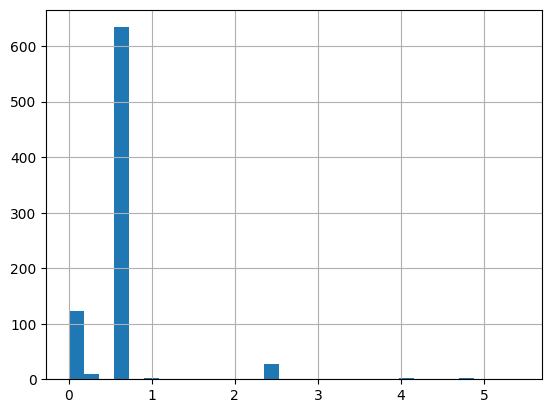

In [16]:
feature_high_confidence['feat_avg_contribution'].hist(bins=30)

Most of correctly predicted examples with high confidence are also related to a <b>low contribution to the site</b> (<code>'create'</code> action)

To summarize, we can conclude the scenario of when the model prediciton can be "fully trusted" as follow:
 - Involving with getting user banned in the same day
 - High level of 'delete' activities (recent + previous)
 - Low average contribution (mostly less than 1 times/day)

## Incorrect Model Prediction (p > 0.8)

In the opposite way from previous analysis, we can also analyze all key attributes that related to incorrect model prediction as follows

In [17]:
log_id_correct = df_pred.loc[df_pred['is_block_next_period'].eq(0) & df_pred['y_pred'].eq(1) & (pred_prob > 0.8), 'log_id']
feature_low_confidence = X.loc[X.index.get_level_values(0).isin(log_id_correct)]

In [18]:
feature_low_confidence['feat_day_since_last_block'].value_counts()

feat_day_since_last_block
0.0    138
1.0     45
2.0      1
Name: count, dtype: int64

In [19]:
feature_low_confidence['feat_is_blocked_recently'].value_counts()

feat_is_blocked_recently
1    184
Name: count, dtype: int64

We can clearly see that all incorrectly predicted examples (with p > 0.8) are also associated with current user blocks (within previous 2 days)

<Axes: >

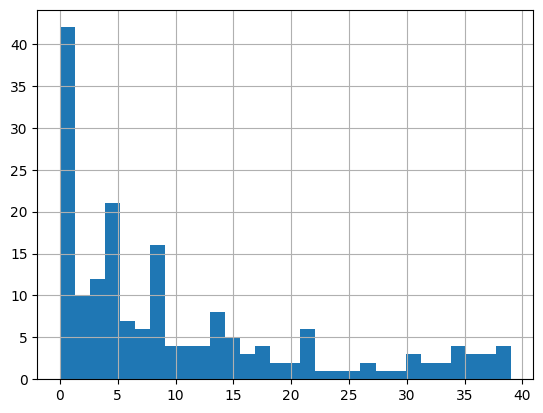

In [20]:
feature_low_confidence['feat_count_delete'].hist(bins=30)

<Axes: >

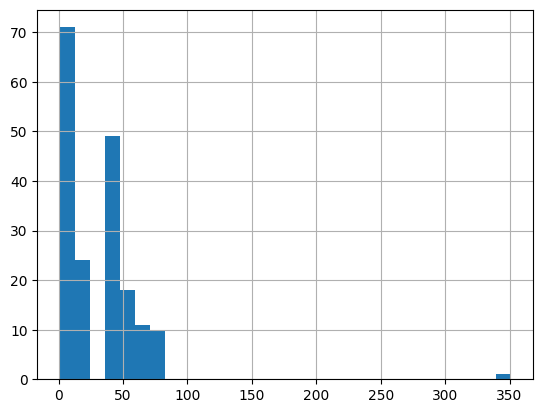

In [21]:
feature_low_confidence['feat_count_delete_hist'].hist(bins=30)

However, incorrectly predicted examples are generally not associated with high level of <code>'delete'</code> activity (as copmpared to the correctly predicted one)

<Axes: >

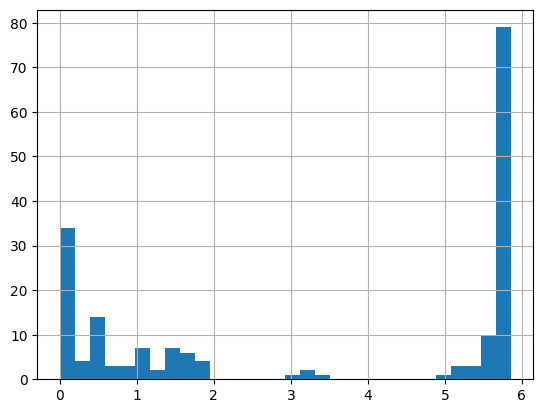

In [22]:
feature_low_confidence['feat_avg_contribution'].hist(bins=30)

As expected, we can see higher level of user contribution to the website (sd compared the previous one)

In summary, the features which mainly drives the incorrect prediction are related to previous user bans that may be irrelevant to the problem -> improve by taking <code>'unblock'</code> into the consideration.

# Future Improvement

From the ongoing model development and post-model analysis, list of ideas for future improvement that arises from the development can be listed here:
 - Additional information to improve model performance
    - User Profile
    - Data Description
    - Page History
 - Solution Improvement
    - Data pre-processing steps to exclude recent user block history (like considering 'unblock' action)
    - Develop new features on new user actions
    - Text processing on comments, such as, Word Embedding, Word Vectorization, Domain Words detection
    - New Solution : Sequential model tahat take into the account both user comments and user action history, such as LSTH, RNN